<a href="https://colab.research.google.com/github/nkaruna09/CNN-google-speech-commands/blob/main/CNN_Google_Speech_Commands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
""" Citations for Code
Author(s): Garcia, M.
Title: Real-time Speech Keyword Recognition using a Convolutional Neural Network (CNN)
Date: August 18, 2020
Code version: n/a
Availability: https://web.archive.org/web/20220515181204/https://marcelmg.github.io/cnn_speech_keyword_recognizer/

Author(s): Naik, K.
Title: Audio-Classification
Date: April 2, 2021
Code version: 2.0
Availability: https://github.com/krishnaik06/Audio-Classification

Author(s): sentence
Title: How to plot precision and recall of multiclass classifier?
Date: May 11, 2019
Code version: n/a
Availability: https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier
"""

' Citations for Code\nAuthor(s): Garcia, M. \nTitle: Real-time Speech Keyword Recognition using a Convolutional Neural Network (CNN)\nDate: August 18, 2020\nCode version: n/a\nAvailability: https://web.archive.org/web/20220515181204/https://marcelmg.github.io/cnn_speech_keyword_recognizer/\n\nAuthor(s): Naik, K. \nTitle: Audio-Classification\nDate: April 2, 2021\nCode version: 2.0\nAvailability: https://github.com/krishnaik06/Audio-Classification \n\nAuthor(s): sentence\nTitle: How to plot precision and recall of multiclass classifier?\nDate: May 11, 2019\nCode version: n/a \nAvailability: https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier\n'

In [ ]:
#Download speech_commands_v0.01.tar.gz
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

#Unzip speech_commands_v0.01.tar.gz
!tar --gunzip --extract --verbose --file=speech_commands_v0.01.tar.gz

Streaming output truncated to the last 5000 lines.
./up/6f9088d7_nohash_0.wav
./up/6f342826_nohash_0.wav
./up/e0a7c5a0_nohash_0.wav
./up/4d4e17f5_nohash_1.wav
./up/b0f24c9b_nohash_0.wav
./up/735845ab_nohash_2.wav
./up/53d5b86f_nohash_0.wav
./up/1a5b9ca4_nohash_1.wav
./up/23abe1c9_nohash_2.wav
./up/bdee441c_nohash_1.wav
./up/a1cff772_nohash_1.wav
./up/1ecfb537_nohash_3.wav
./up/37fc5d97_nohash_3.wav
./up/bd8412df_nohash_1.wav
./up/e53139ad_nohash_1.wav
./up/10ace7eb_nohash_3.wav
./up/30065f33_nohash_0.wav
./up/eefd26f3_nohash_0.wav
./up/c9b653a0_nohash_2.wav
./up/02746d24_nohash_0.wav
./up/e1469561_nohash_0.wav
./up/4bba14ce_nohash_0.wav
./up/b5d1e505_nohash_1.wav
./up/531a5b8a_nohash_1.wav
./up/0135f3f2_nohash_0.wav
./up/dbb40d24_nohash_4.wav
./up/e9287461_nohash_1.wav
./up/71e6ab20_nohash_0.wav
./up/ead2934a_nohash_1.wav
./up/f9af0887_nohash_0.wav
./up/ff63ab0b_nohash_0.wav
./up/f3d06008_nohash_0.wav
./up/918a2473_nohash_4.wav
./up/e54a0f16_nohash_0.wav
./up/cb8f8307_nohash_1.wav
./up

In [ ]:
#Imports
import csv

import pandas as pd
import os
import librosa
import numpy as np

from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Dense,Activation,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from scipy.io import wavfile
!pip install python_speech_features
import python_speech_features

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

!pip install livelossplot
%matplotlib inline
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras

from datetime import datetime
from timeit import default_timer as timer
from IPython.display import clear_output


  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5869 sha256=89cd1a2d4ba360769b91163dfb35bd5f4d172936478239236bca0bef31147c36
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [ ]:
#Assign each google speech command an integer value to help classify
word2index = {
    "bed": 1,
    "bird": 2,
    "cat": 3,
    "dog": 4,
    "down": 5,
    "eight": 6,
    "five": 7,
    "four": 8,
    "go": 9,
    "happy": 10,
    "house": 11,
    "left": 12,
    "marvin": 13,
    "nine": 14,
    "no": 15,
    "off": 16,
    "on": 17,
    "one": 18,
    "right": 19,
    "seven": 20,
    "sheila": 21,
    "six": 22,
    "stop": 23,
    "three": 24,
    "tree": 25,
    "two": 26,
    "up": 27,
    "wow": 28,
    "yes": 29,
    "zero": 30,
}

index2word = [word for word in word2index]

In [ ]:
#Import file names and classes from speech_commands_v0.01.tar.gz into csv file
def file_to_csv(file_name, num_classes, num_samples_per_class):
  path = '/content/'

  with open(file_name+'.csv', 'w') as csv_file: #open a csv file
    header = ['class', 'file_name', 'classID']
    writer = csv.writer(csv_file)
    writer.writerow(header)

    for word_class in word2index:
      folder = path+word_class # folder name
      count = 0
      for file in os.listdir(folder): # iterate through all the files in the folder
        stats = os.stat(os.path.join(folder+'/',file)) # file name
        if stats.st_size == 32044: #only include files that are 1 second long
          data = [word_class, file, word2index[word_class]]
          writer.writerow(data) # inputs the class, file name, and class index into the csv file
          count +=1
        if count >= num_samples_per_class:
          break


file_name='speech_commands'
num_classes = len(word2index)
num_samples_per_class = 1000

file_to_csv(file_name, num_classes, num_samples_per_class)

#read csv file into a data frame
tl_csv = pd.read_csv('speech_commands.csv')
tl_csv.head()

,class,file_name,classID
0,bed,d486fb84_nohash_1.wav,1
1,bed,eee9b9e2_nohash_0.wav,1
2,bed,ab5d7179_nohash_0.wav,1
3,bed,83f9c4ab_nohash_0.wav,1
4,bed,179a61b7_nohash_0.wav,1


In [ ]:
#Load .wav file and compute MFCC features
def wav2feature(filepath):
    samplerate, data = wavfile.read(filepath)
    data = data.astype(np.float)
    # compute MFCC coefficients
    features = python_speech_features.mfcc(data, samplerate=16000, winlen=0.025, winstep=0.01, numcep=20, nfilt=40, nfft=512, lowfreq=100, highfreq=None, preemph=0.97, ceplifter=22, appendEnergy=True, winfunc=np.hamming)
    return features

#Iternate through every audio file and extract features using MFCCs
features=np.empty((num_classes*num_samples_per_class, )+(99,20), dtype=np.float)
extracted_features = [] #store extracted features into seperate array
path = "/content/"

for index_num, row in tqdm(tl_csv.iterrows()): #iterate through each row in csv file and collect MFCC features
  file_name = os.path.join(path,str(row["class"])+'/',str(row["file_name"]))
  data = wav2feature(file_name) #extract MFCC features
  extracted_features.append([data, row["classID"]]) #add data into numpy array
  features[index_num]=data

<ipython-input-6-f5fd757d5dfa>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  features=np.empty((num_classes*num_samples_per_class, )+(99,20), dtype=np.float)
0it [00:00, ?it/s]<ipython-input-6-f5fd757d5dfa>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)
30000it [03:31, 142.00it/s]


In [ ]:
#Converting extracted_features to Pandas dataframa
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[[7.126941258946928, -23.23631745309347, -8.26...",1
1,"[[8.113475985726094, -28.431107897972893, -15....",1
2,"[[11.532844416123732, -23.693008050256545, -4....",1
3,"[[19.164284078885526, -16.893676949003968, -52...",1
4,"[[14.564048458592998, -33.76017072502562, -12....",1


In [ ]:
#Split the dataset into independent and dependent dataset
X = np.array(extracted_features_df['feature'].tolist())
Y = np.array(extracted_features_df['class'].tolist())

#Remove single-dimensional entries from X and Y
np.squeeze(X, axis=None)
np.squeeze(Y, axis=None)


array([ 1,  1,  1, ..., 30, 30, 30])

In [ ]:
#Label Encoding
labelencoder=LabelEncoder()
Y=to_categorical(labelencoder.fit_transform(Y))

In [ ]:
print("X shape:")
print(X.shape)
print("Y shape:")
print(Y.shape)

X shape:
(30000, 99, 20)
Y shape:
(30000, 30)


In [ ]:
#Split the data set into training and testing sets
X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=0.30, random_state=42, shuffle=True)

In [ ]:
print("X_train shape: ")
print(X_train.shape)
print("X_test shape: ")
print(X_test.shape)
print("Y_train shape: ")
print(Y_train.shape)
print("Y_test shape: ")
print(Y_test.shape)

X_train shape: 
(21000, 99, 20)
X_test shape: 
(9000, 99, 20)
Y_train shape: 
(21000, 30)
Y_test shape: 
(9000, 30)


In [ ]:
#Number of classes
num_labels = Y.shape[1]

In [ ]:
keras.backend.clear_session() #clears previous model

model = Sequential()

#First layer
model.add(Input(shape=(99,20)))
model.add(Conv1D(64, kernel_size=8, activation="relu"))
model.add(MaxPooling1D(pool_size=3))
#Second layer
model.add(Conv1D(128, kernel_size=5, activation="relu"))
model.add(MaxPooling1D(pool_size=3))
#Third layer
model.add(Conv1D(256, kernel_size=5, activation="relu"))
model.add(GlobalMaxPooling1D())
#Final layer
model.add(Flatten())
model.add(Dense(256, activation ="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(num_labels, activation='softmax'))

#Print model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 92, 64)            10304     
                                                                 
 max_pooling1d (MaxPooling1  (None, 30, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 128)           41088     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 8, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 256)            164096    
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0

In [ ]:
#Optimization algorithm and Loss algorithm
sgd = keras.optimizers.SGD(learning_rate=0.01)
loss_fn = keras.losses.CategoricalCrossentropy()
#compile model
model.compile(optimizer=sgd, loss=loss_fn, metrics=["accuracy"])

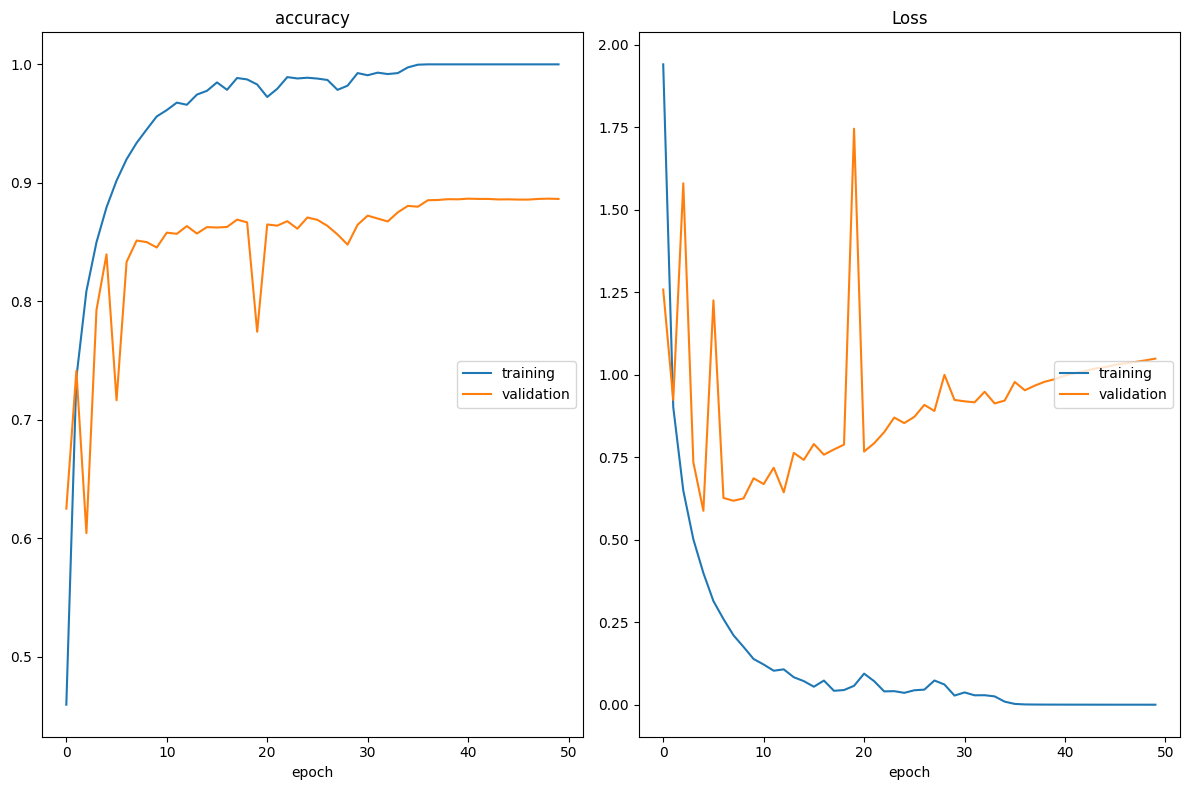

accuracy
	training         	 (min:    0.460, max:    1.000, cur:    1.000)
	validation       	 (min:    0.604, max:    0.887, cur:    0.886)
Loss
	training         	 (min:    0.000, max:    1.941, cur:    0.000)
	validation       	 (min:    0.588, max:    1.746, cur:    1.049)

Epoch 50: val_loss did not improve from 0.58790
657/657 [==============================] - 24s 36ms/step - loss: 1.9605e-04 - accuracy: 1.0000 - val_loss: 1.0491 - val_accuracy: 0.8864
Training completed in time:  0:20:41.139376


In [ ]:
#Training model and measuring accuracy and loss
checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', verbose=1, save_best_only=True)
start = datetime.now() #start training
history = model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_test, Y_test), callbacks=[PlotLossesKeras(), checkpointer], verbose=1) #fit model (training)
duration = datetime.now() - start #end training
print("Training completed in time: ", duration)

In [ ]:
# save model
model.save(datetime.now().strftime("%d_%m_%Y__%H_%M")+".h5")

In [ ]:
#overall accuracy
test_accuracy=model.evaluate(X_test,Y_test,verbose=0)
print(test_accuracy[1])

0.8864444494247437


282/282 [==============================] - 2s 8ms/step


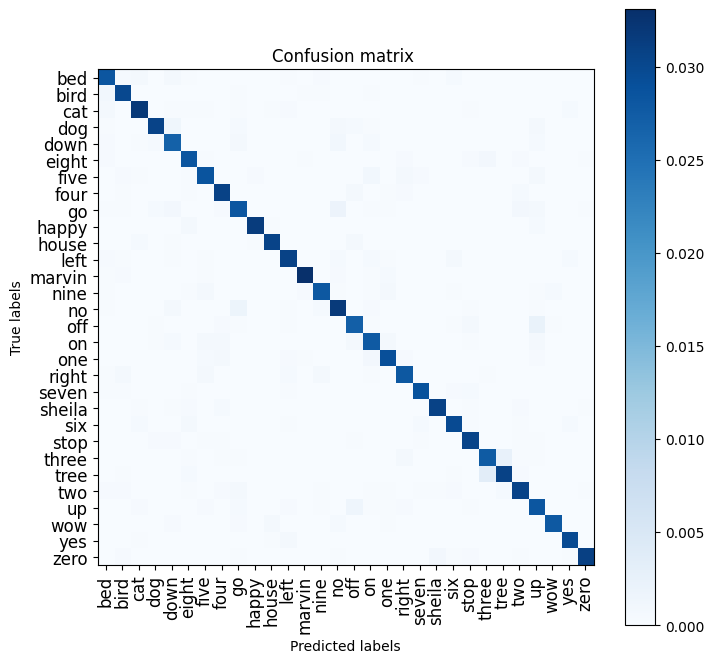

In [ ]:
#confusion matrix
y_test_arg=np.argmax(Y_test,axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test_arg, y_pred,  normalize="all")
%matplotlib inline
plt.close()
plt.figure(figsize = (8,8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(0, 30, 1), index2word, rotation=90)
plt.yticks(np.arange(0, 30, 1), index2word)
plt.tick_params(labelsize=12)
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()


In [ ]:
#Imports
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, precision_score, roc_auc_score
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
#%matplotlib inline

282/282 [==============================] - 2s 8ms/step


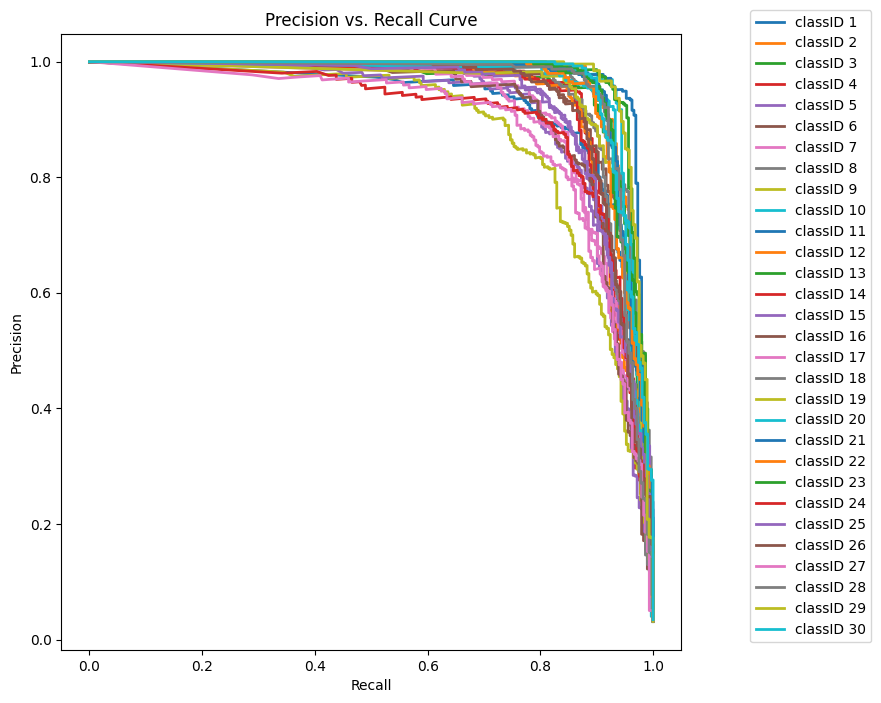

In [ ]:
y_pred = model.predict(X_test)
Y_d2 = Y #copy Y
X_d2 = X #copy X

nsamples, nx, ny = X_d2.shape
X_d2_train = X_d2.reshape((nsamples,nx*ny)) #reshape to 2-D

Y_d2 = label_binarize(Y_d2, classes=[*range(num_classes)])

#Precision-Recall curve
precision = dict()
recall = dict()
plt.figure(figsize = (8,8))

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='classID {}'.format(i+1))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Precision vs. Recall Curve")
plt.show()

In [ ]:
#Precision score for each class
for i in range(num_classes):
    print(precision_score(Y_test[:, i], y_pred[:, i].round()))

#ROC_AUC score for each class
for i in range(num_classes):
    print(roc_auc_score(Y_test[:, i], y_pred[:, i].round()))

0.8518518518518519
0.9026845637583892
0.8913043478260869
0.935374149659864
0.8275862068965517
0.8677966101694915
0.8771331058020477
0.8846153846153846
0.834983498349835
0.9593220338983051
0.9515570934256056
0.9013157894736842
0.9581993569131833
0.9194139194139194
0.8666666666666667
0.8652482269503546
0.8412162162162162
0.8915254237288136
0.9057971014492754
0.9413919413919414
0.9484536082474226
0.9075342465753424
0.9013157894736842
0.8322147651006712
0.8964401294498382
0.9042904290429042
0.8
0.943609022556391
0.9366197183098591
0.9653979238754326
0.9367108585858586
0.9589513028485851
0.9520987236821391
0.935414096553993
0.9211603093909753
0.9422061524334252
0.9192413201481914
0.9579310344827586
0.8974375980269258
0.9632443744756267
0.9668830316413265
0.934578815606342
0.9634255206196501
0.9314957045013659
0.9294863908938298
0.912783583454057
0.9222156979339914
0.9454410985620988
0.9386493352035111
0.953145857308999
0.9560913751962467
0.9491296173879613
0.959555917673808
0.92471594283225

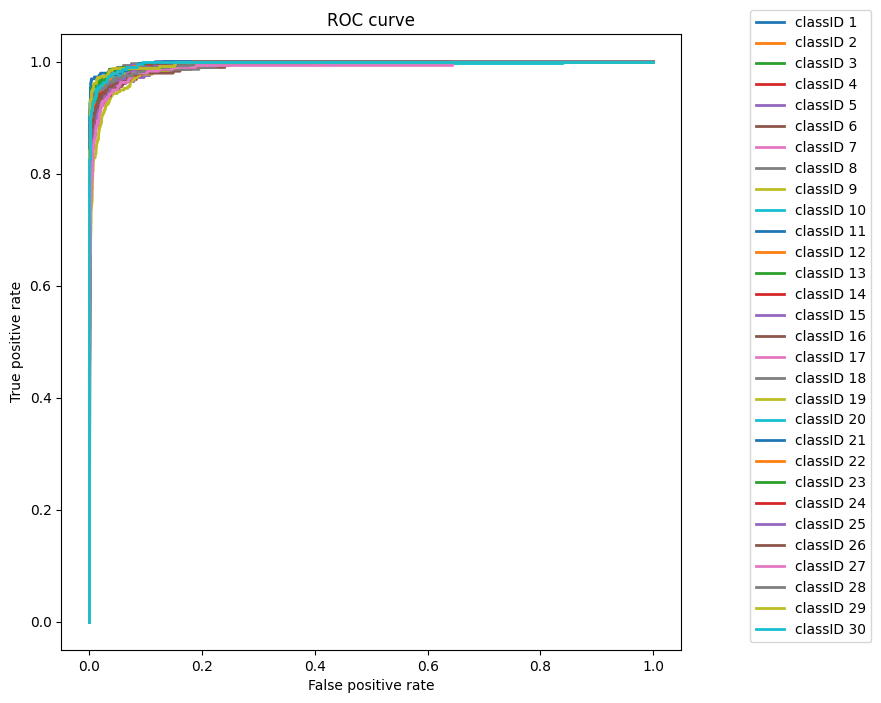

In [ ]:
#ROC curve
fpr = dict()
tpr = dict()

plt.figure(figsize = (8,8))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='classID {}'.format(i+1))

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("ROC curve")
plt.show()

In [ ]:
https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier

SyntaxError: invalid syntax (<ipython-input-24-bb6682194722>, line 1)

In [ ]:
#Display graph of one file
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

filename = '/content/cat/004ae714_nohash_0.wav'

y, sr = librosa.load(filename)

mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');